In [ ]:
!pip install cartopy
import cartopy.feature as cfeature
!pip install regionmask
!pip install netCDF4
!apt-get install -y cdo
!pip install cmocean

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 76.4 MB/s eta 0:00:00


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cmocean
import numpy as np
import cmocean as cmo
import pandas as pd
import regionmask
import cartopy.crs as ccrs
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

In [ ]:
data = xr.open_dataset('/content/cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1760548338825.nc')

In [ ]:
data

<xarray.Dataset> Size: 54MB
Dimensions:    (time: 1114, depth: 13, latitude: 28, longitude: 33)
Coordinates:
  * time       (time) datetime64[ns] 9kB 2022-10-07 2022-10-08 ... 2025-10-24
  * depth      (depth) float32 52B 0.494 1.541 2.646 3.819 ... 15.81 18.5 21.6
  * latitude   (latitude) float32 112B 17.58 17.67 17.75 ... 19.67 19.75 19.83
  * longitude  (longitude) float32 132B -69.92 -69.83 -69.75 ... -67.33 -67.25
Data variables:
    thetao     (time, depth, latitude, longitude) float32 54MB ...
Attributes:
    Conventions:       CF-1.11
    title:             daily mean fields from Global Ocean Physics Analysis a...
    institution:       Mercator Ocean International
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            MOI GLO12
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    references:        http://marine.copernicus.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_ANALYSISFORECAST_PHY_001_024
    subset:datasetId:  cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_202406
    subset:date:       2025-10-15T17:12:18.825Z

In [ ]:
sst= data['thetao'][:]

**Extraccion de Coordenadas**

In [ ]:
lon = sst.longitude
lat= sst.latitude

**Extraccion de data para graficarla**

# **Graficar Area de la data**

**Remover la data que cae sobre tierra la tierra**

In [ ]:
tierra= regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(lon, lat)
data_masked= data.where(tierra.isnull())

**Remover la data fuera de la Bahia**

**Elegir periodo a graficar**

In [ ]:
print(data_masked)

<xarray.Dataset> Size: 54MB
Dimensions:    (time: 1114, depth: 13, latitude: 28, longitude: 33)
Coordinates:
  * time       (time) datetime64[ns] 9kB 2022-10-07 2022-10-08 ... 2025-10-24
  * depth      (depth) float32 52B 0.494 1.541 2.646 3.819 ... 15.81 18.5 21.6
  * latitude   (latitude) float32 112B 17.58 17.67 17.75 ... 19.67 19.75 19.83
  * longitude  (longitude) float32 132B -69.92 -69.83 -69.75 ... -67.33 -67.25
Data variables:
    thetao     (time, depth, latitude, longitude) float32 54MB 29.46 ... 29.32
Attributes:
    Conventions:       CF-1.11
    title:             daily mean fields from Global Ocean Physics Analysis a...
    institution:       Mercator Ocean International
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            MOI GLO12
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    references:        http://marine.copernicus.eu
    subset:sour

In [ ]:
temp = data_masked['thetao']

In [ ]:
print('La temperatura maxima es {}'.format(temp.max()))
print('La temperatura maxima es {}'.format(temp.min()))

La temperatura maxima es <xarray.DataArray 'thetao' ()> Size: 8B
array(31.93841362)
La temperatura maxima es <xarray.DataArray 'thetao' ()> Size: 8B
array(25.16387367)


In [ ]:
temp_superficie = temp.sel(depth=0.49, method= 'nearest')
data_promedio = temp_superficie.mean(dim='time')

**Grafica de Zona de estudio**

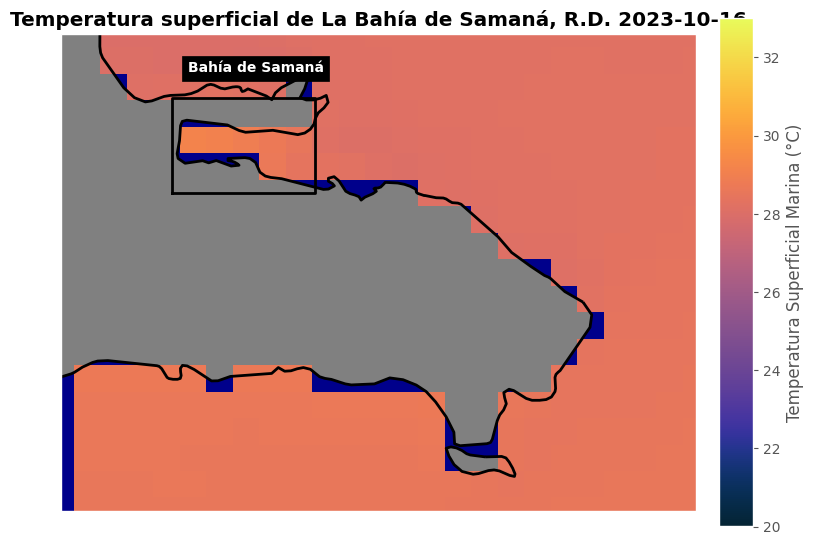

In [ ]:
fig = plt.figure(figsize=(10,11))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
mesh = ax.pcolormesh(
    lon, lat, data_promedio ,
    transform=ccrs.PlateCarree(),
    cmap=cmo.cm.thermal,
    vmin=20, vmax=33,
    shading='nearest'
)
ax.coastlines(resolution='10m', color='black', linewidth=2)
ax.add_feature(cfeature.LAND, facecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.OCEAN, facecolor= 'darkblue')
ax.set_extent([-70.0, -68.0, 18.0, 19.5], crs=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.03,
                    aspect=15, shrink=0.6)
# coordenadas para encerrar en un recuadro a la Bahia de Samana
lon_min = -69.65
lon_max = -69.2
lat_min = 19.0
lat_max = 19.3
lons = [lon_min, lon_min, lon_max, lon_max, lon_min]
lats = [lat_min, lat_max, lat_max, lat_min, lat_min]
ax.plot(lons, lats, color= 'k', linewidth= 2,
        transform= ccrs.PlateCarree())
ax.text(lon_min + 0.05, lat_max + 0.08, 'Bahía de Samaná',
        color= 'white', fontsize= 10, fontweight= 'bold',
        bbox= dict(facecolor= 'black', edgecolor='black'),
        transform= ccrs.PlateCarree())

cbar.set_label('Temperatura Superficial Marina (°C)')
ax.set_title('Temperatura superficial de La Bahía de Samaná, R.D. 2023-10-16', fontweight='bold')
plt.show()

# **Analisis Temporal de la Temperatura**

**Corte de pixels con data de temperatura**

In [ ]:
lat_min = 19.0
lat_max = 19.3
lon_min = -69.5
lon_max = -69.0
bahia_samana = temp_superficie.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max)
)

In [ ]:
sst_media = bahia_samana.mean(dim=['latitude','longitude'])

**Grafica de Evolucion de la temperatura en el Tiempo**

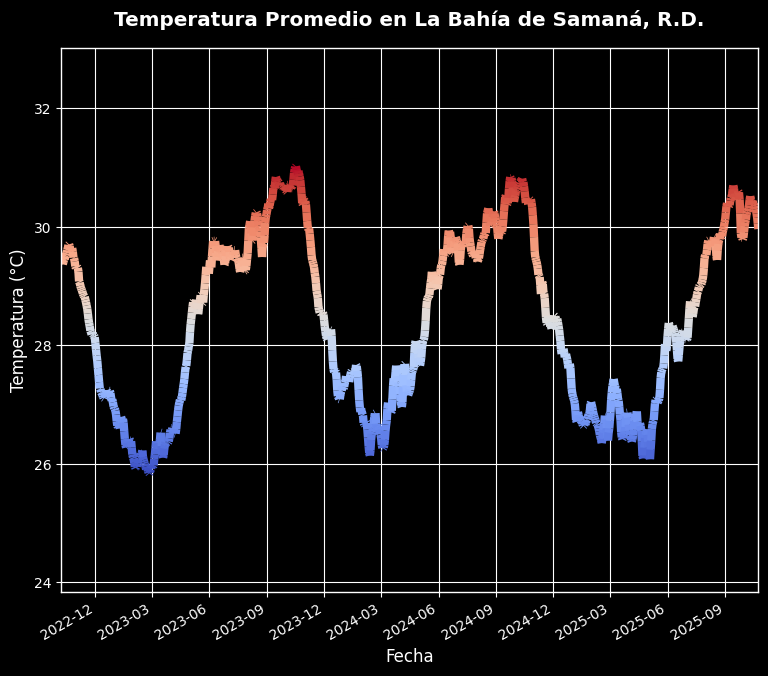

In [ ]:
plt.style.use('dark_background')

temperaturas = sst_media.values

tiempo = sst_media.time.values
fechas= mdates.date2num(tiempo)

puntos = np.array([fechas, temperaturas]).T.reshape(-1, 1, 2)

segmentos= np.concatenate([puntos[:-1], puntos[1:]], axis= 1)

normal= plt.Normalize(temperaturas.min(), temperaturas.max())

coleccion = LineCollection(segmentos, cmap= 'coolwarm', norm= normal)

coleccion.set_array((temperaturas[:-1] + temperaturas[1:]) / 2)
coleccion.set_linewidth(6)

fig, ax =  plt.subplots(figsize = (9, 8))
ax.add_collection(coleccion)
ax.set_xlim(fechas.min(), fechas.max())

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

ax.set_ylim(temperaturas.min() - 2, temperaturas.max() + 2)

ax.set_title('Temperatura Promedio en La Bahía de Samaná, R.D.', fontweight= 'bold',
             pad= 16)
ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura (°C)')
ax.grid(True)
plt.show()